<a href="https://colab.research.google.com/github/NesterukSergey/Computer-Vision-for-Intro-to-Digital-Argo-course/blob/main/Intro_to_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import os
import copy
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

plt.ion()

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Load dataset

In [3]:
!rm -rf ./Computer-Vision-for-Intro-to-Digital-Argo-course
!git clone https://github.com/NesterukSergey/Computer-Vision-for-Intro-to-Digital-Argo-course.git

Cloning into 'Computer-Vision-for-Intro-to-Digital-Argo-course'...
remote: Enumerating objects: 2950, done.
remote: Counting objects: 100% (2950/2950), done.
remote: Compressing objects: 100% (2949/2949), done.
remote: Total 2950 (delta 6), reused 2938 (delta 1), pack-reused 0
Receiving objects: 100% (2950/2950), 60.22 MiB | 45.85 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [4]:
data_path =  './Computer-Vision-for-Intro-to-Digital-Argo-course/Antarctic_classification_mini_dataset/'

In [5]:
train_data_path = '{}/train'.format(data_path)
valid_data_path = '{}/validation'.format(data_path)
holdout_data_path = '{}/holdout'.format(data_path)

In [6]:
train_dataset = datasets.ImageFolder(root=train_data_path)

Sample class: 0
Sample type: <class 'PIL.Image.Image'>


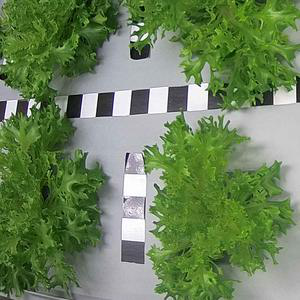

In [7]:
print('Sample class:', train_dataset[0][1])
print('Sample type:', type(train_dataset[0][0]))

train_dataset[0][0]

Explore the list of [Pytorch transforms](https://pytorch.org/docs/stable/torchvision/transforms.html)

In [8]:
data_transforms = {
    'train': transforms.Compose([
      transforms.Resize(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'val': transforms.Compose([
      transforms.Resize(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

More on [Pytorch datasets and dataloaders](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [9]:
train_dataset = datasets.ImageFolder(root=train_data_path, transform=data_transforms['train'])
valid_dataset = datasets.ImageFolder(root=valid_data_path, transform=data_transforms['val'])
holdout_dataset = datasets.ImageFolder(root=holdout_data_path, transform=data_transforms['val'])

In [10]:
print('Sample class:', train_dataset[0][1])
print('Sample type:', type(train_dataset[0][0]))
print('Sample size:', train_dataset[0][0].shape)

Sample class: 0
Sample type: <class 'torch.Tensor'>
Sample size: torch.Size([3, 224, 224])


In [11]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=8, shuffle=True, num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=8, shuffle=False, num_workers=4)
holdout_dataloader = torch.utils.data.DataLoader(dataset=holdout_dataset, batch_size=8, shuffle=False, num_workers=4)

In [12]:
print('Batch shape:', next(iter(train_dataloader))[0].shape)

Batch shape: torch.Size([8, 3, 224, 224])


# Create model

Learn more about [layer types](https://arxiv.org/abs/1603.07285)

In [13]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()

    # (batch size ommited) [channels, H, W]

    self.cnn_layers = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0),  # [3, 56, 56] -> [16, 52, 52]
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0),  # [16, 52, 52] -> [32, 48, 48]
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),  # [32, 48, 48] -> [32, 24, 24]

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),  # [32, 24, 24] -> [64, 22, 22]
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Dropout(),

        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0),  # [64, 24, 24] -> [64, 20, 20]
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),  # [64, 20, 20] -> [64, 10, 10]

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),  # [64, 10, 10] -> [128, 8, 8]
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0),  # [128, 8, 8] -> [256, 6, 6]
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2), # [256, 6, 6] -> [256, 3, 3]
        nn.Dropout()
    )

    self.linear_layers = nn.Sequential(
        nn.Linear(in_features=256*3*3, out_features=128),  # [1, 2304] -> [128]
        nn.ReLU(inplace=True),

        nn.Linear(in_features=128, out_features=3)  # [128] -> [3]
    )


  def forward(self, x):
    
    x = nn.functional.interpolate(x, 56)  # [3, 224, 224] -> [3, 56, 56]
    x = self.cnn_layers(x)  # [3, 56, 56] -> [256, 3, 3]
    x = x.view(x.size(0), -1)  # [256, 3, 3] -> [2304]
    x = self.linear_layers(x)  # [2304] -> [3]
    return x

More about [optimizers](https://pytorch.org/docs/stable/optim.html) and [loss functions](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=loss#torch.nn.CrossEntropyLoss)

In [14]:
model = SimpleCNN()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

criterion = torch.nn.CrossEntropyLoss()
criterion.to(device);

In [15]:
def train_epoch(dloader, model):

    model.train()

    train_epoch_loss = .0
    train_epoch_corrects = 0

    for img, label in dloader:

        img, label = img.to(device), label.to(device)

        optimizer.zero_grad()

        output = model(img)
        pred = torch.max(output, 1)[1]

        loss = criterion(output, label)

        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()
        train_epoch_corrects += torch.sum(pred == label.data)

    return train_epoch_loss, (train_epoch_corrects / len(train_dataset))

In [16]:
def valid_epoch(dloader, model):

    model.eval()

    valid_epoch_loss = .0
    valid_epoch_corrects = 0
    total = 0

    for img, label in dloader:

        img, label = img.to(device), label.to(device)

        with torch.no_grad():

            output = model(img)
            pred = torch.max(output, 1)[1]

            loss = criterion(output, label)

            valid_epoch_loss += loss.item()
            valid_epoch_corrects += torch.sum(pred == label.data)
            total += len(label.data)

    return valid_epoch_loss, (valid_epoch_corrects / total)

In [17]:
def train(model, criterion, optimizer, num_epochs=3):

    hist = {
        'train_loss_hist': [],
        'train_acc_hist': [],
        'valid_loss_hist': [],
        'valid_acc_hist': []
    }

    for epoch in tqdm(range(num_epochs)):

        train_epoch_loss, train_epoch_acc = train_epoch(train_dataloader, model)
        hist['train_loss_hist'].append(train_epoch_loss)
        hist['train_acc_hist'].append(train_epoch_acc)

        valid_epoch_loss, valid_epoch_acc = valid_epoch(train_dataloader, model)
        hist['valid_loss_hist'].append(valid_epoch_loss)
        hist['valid_acc_hist'].append(valid_epoch_acc)

    return hist

In [18]:
hist = train(model, criterion, optimizer, num_epochs=10)

100%|██████████| 10/10 [00:57<00:00,  5.75s/it]


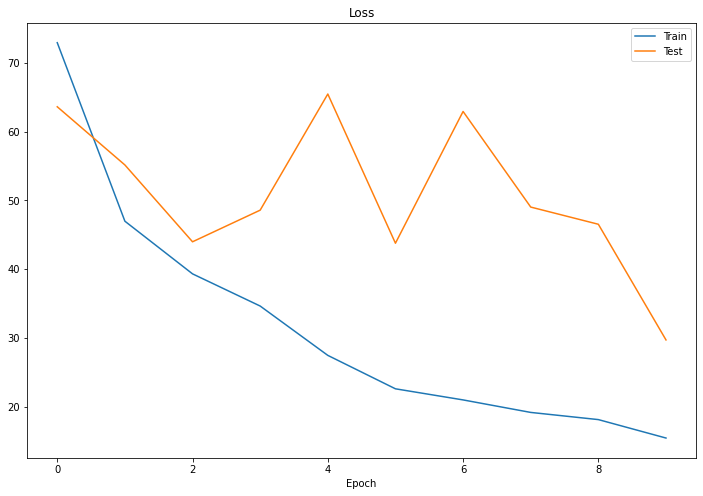

In [19]:
fig = plt.figure(figsize=(12, 8))
plt.title('Loss')
plt.plot(list(range(len(hist['train_loss_hist']))), hist['train_loss_hist'], label='Train')
plt.plot(list(range(len(hist['valid_loss_hist']))), hist['valid_loss_hist'], label='Test')
plt.xlabel('Epoch')
plt.legend()
plt.show()

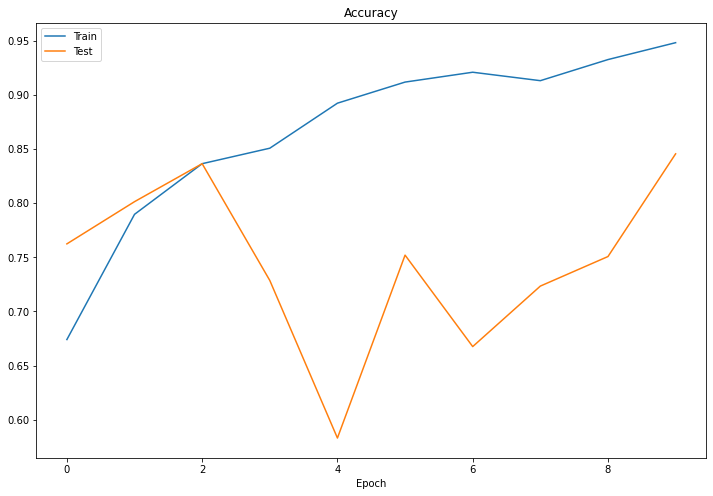

In [20]:
fig = plt.figure(figsize=(12, 8))
plt.title('Accuracy')
plt.plot(list(range(len(hist['train_acc_hist']))), hist['train_acc_hist'], label='Train')
plt.plot(list(range(len(hist['valid_acc_hist']))), hist['valid_acc_hist'], label='Test')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Use small pre-trained model

In [21]:
resnet18 = models.resnet18(pretrained=True)
num_linear_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_linear_features, 3)

resnet18.to(device)

optimizer = torch.optim.SGD(resnet18.parameters(), lr=1e-4, momentum=0.9)

criterion = torch.nn.CrossEntropyLoss()
criterion.to(device);

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [22]:
resnet18_hist = train(resnet18, criterion, optimizer, num_epochs=10)

100%|██████████| 10/10 [01:08<00:00,  6.89s/it]


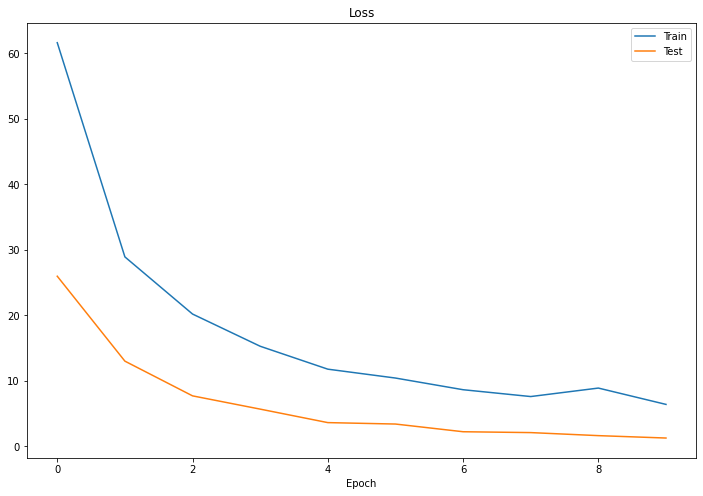

In [23]:
fig = plt.figure(figsize=(12, 8))
plt.title('Loss')
plt.plot(list(range(len(resnet18_hist['train_loss_hist']))), resnet18_hist['train_loss_hist'], label='Train')
plt.plot(list(range(len(resnet18_hist['valid_loss_hist']))), resnet18_hist['valid_loss_hist'], label='Test')
plt.xlabel('Epoch')
plt.legend()
plt.show()

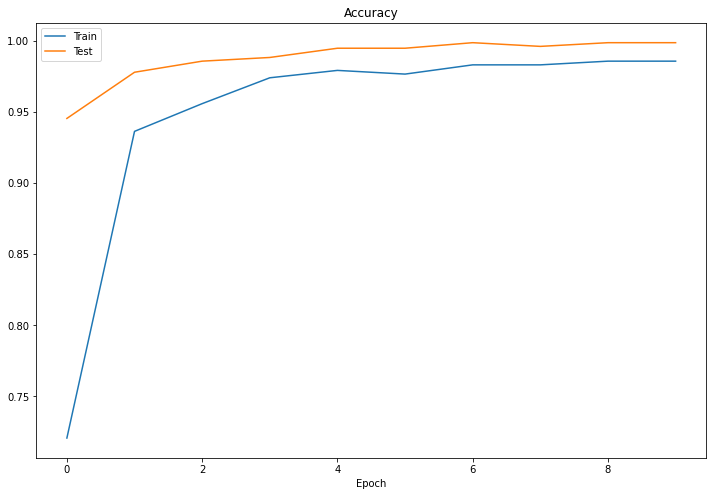

In [24]:
fig = plt.figure(figsize=(12, 8))
plt.title('Accuracy')
plt.plot(list(range(len(resnet18_hist['train_acc_hist']))), resnet18_hist['train_acc_hist'], label='Train')
plt.plot(list(range(len(resnet18_hist['valid_acc_hist']))), resnet18_hist['valid_acc_hist'], label='Test')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [24]:
resnet18